In [1]:
import os, glob
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "../src")
import auxilary_functions as f
from generation_algorithm import *
import subprocess
import csv
import matplotlib.pyplot as plt
import json
import networkx as nx

cfg_file = "../src/config-ecoli.json"

In [2]:
def load_ffl_based_component():
    with open(cfg_file, 'r') as j:
        config_file = json.loads(j.read())
            
        interaction_matrix = f.get_interaction_matrix(config_file)
        motifs, counter = f.motif_search(config_file, interaction_matrix, batch_size=10000)
        motifs_orig = motifs["030T"]

        ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
        interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
        for motif in motifs_orig:
            motif = f.split_motif(motif)
            motif_new = list(ffl_nodes.index(x) for x in motif)
            interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
            interaction_matrix[np.ix_(motif, motif)]
        interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

        # Vertex-based motif network on FFL
        motifs_network = f.build_vmn(motifs_orig, verbose=True)
        V = nx.Graph(motifs_network)
        nx.is_connected(V)
        return interaction_matrix, motifs_orig, motifs_network, interaction_matrix_ffl

In [3]:
out_degrees = []
list_of_matrices = []

for i in range(16):
    
    yeast_matrix, ffl_motif, ffl_component, ffl_matrix = load_ffl_based_component()
    
    substrate_matrix = get_network_nucleus(
        yeast_matrix, ffl_motif, ffl_component, min_size=20, random_seed=np.random.randint(1,100)
    )
    
    list_of_matrices.append(substrate_matrix.transpose())
    
    out_degree = []
    
    for i in range(substrate_matrix.shape[0]):
        out_degree.append(substrate_matrix[:i].sum()/substrate_matrix.shape[0])
        
    out_degrees.append(out_degree)

100%|██████████| 5676765/5676765 [00:12<00:00, 466545.33it/s]


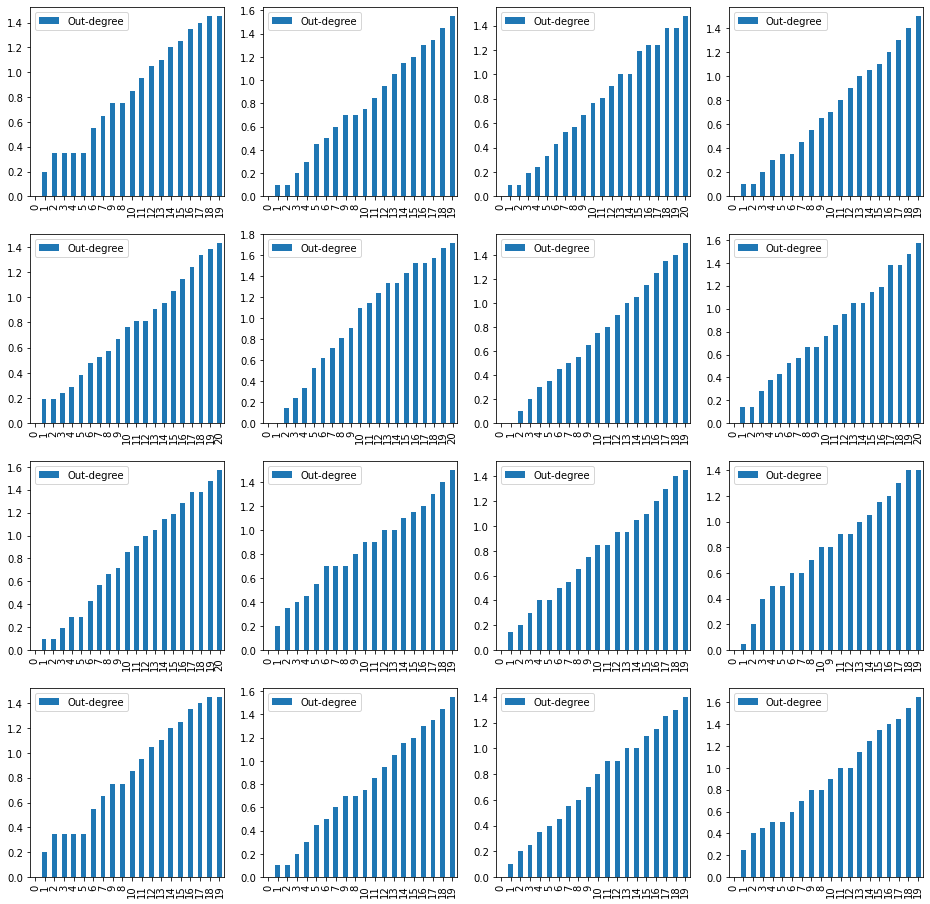

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))

for i in range(16):
    a = pd.DataFrame({'Out-degree': out_degrees[i]}).sort_values(['Out-degree'])
    a.plot(kind='bar', ax=axes.flat[i])

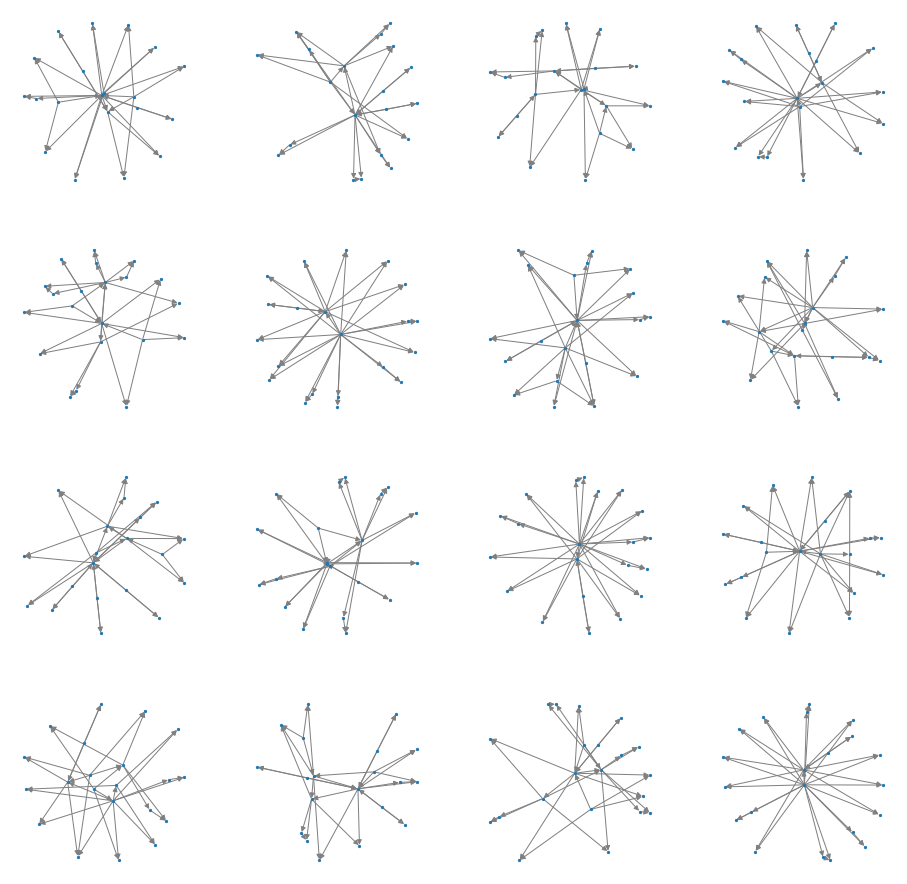

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))

for num, i in enumerate(list_of_matrices):
    substrate_matrix_graph = nx.DiGraph(i)
    nx.draw(substrate_matrix_graph, node_size = 5, edge_color = 'gray', ax=axes.flat[num])